# 2D Sticker Task Generation:
In this notebook, we will show how to generate 2D grid ImageQA test cases in TaskVerse, we will use 6 task generators, including `WhatGridTaskGenerator`, `WhereManyGridTaskGenerator`, `HowManyGridTaskGenerator`, `WhatAttributeGridTaskGenerator`, and `WhereAttributeGridTaskGenerator`.

## Requirements

If you want to run this notebook, you need to add `..` to python package search path. You can do this by running the following command in the root directory of the repository:

In [1]:
import sys
sys.path.append("../..")

## Download TaskVerse source data from huggingface
The source metadata of TaskVerse is available at [Huggingface](https://huggingface.co/datasets/weikaih/Dynabench), you can download it by running the following command:

In [2]:
# from huggingface_hub import snapshot_download

# path = "/your/path/to/save/sourcedata"
# snapshot_download(repo_id="jieyuz2/taskmeanything-v1-source", repo_type="dataset", local_dir=path)

## Using TaskGenerator to enumerate task plans and store them into local parquet file

* `TaskGenerator` is a class used to enumerate all the possible task plans from the source metadata, and generate VQA test cases based on the task plans. (e.g. `WhatGridTaskGenerator`)
* `TaskStore` is a class designed to handle the task plan generated by the task generator. The task store can output data in a pandas dataframe format.
  
In this notebook, instead of using a single type of generator, we will use multiple types of generators to generate test cases. So we introduce a new class `JointTaskGenerator`:
* `JointTaskGenerator` is a class to assemble multiple `TaskGenerator` into a joint task generator. 

After downloading the source data, we first create a `Objaverse2DMetaData` object to load the metadata from Objaverse. Then you can first create a dict of TaskGenerator, and then pass it to `JointTaskGenerator` to create a joint task generator. This generator has the same interface as a single task generator, but it will generate tasks from all the task generators in the dict.

In [3]:
from tma.imageqa.sticker_2d import *
from tma.base import JointTaskGenerator
from tma.imageqa.metadata import Objaverse2DMetaData


path = '/your_path/dynabench-source/object_images'  # path to object images
metadata = Objaverse2DMetaData('../../annotations', image_folder=path)

generators = {
    'what'              : WhatGridTaskGenerator,
    'where'             : WhereGridTaskGenerator,
    'how many'          : HowManyGridTaskGenerator,
    'what attribute'    : WhatAttributeGridTaskGenerator,
    'where attribute'   : WhereAttributeGridTaskGenerator
}
generator = JointTaskGenerator(metadata, generators)

Once you feed the metadata to the task generator, we can start to enumerate all the possible task plans by using `generator.enumerate_task_plans()` method. We also need to initialize `TaskStore` to store the task plans. When we initialize `TaskStore` with a `output_file`, it will save the task plans to a local parquet file without holding them in memory. After task plans enumeration, use `task_store.close()` method to make sure the parquet writer is appropriately closed. 

Note that `buffer_size` is the maximum number of task plans to hold in memory before writing to the parquet file which save in disk. If your memory is limited, you can set a smaller buffer_size to avoid memory overflow. Typically, `1e6` is a good choice for server which has less than 32GB memory.


In [4]:
from tma.task_store import TaskStore

save_path = '../cache/2d_sticker.parquet'  # path to save task plans to a parquet
task_store = TaskStore(output_file=save_path, schema=generator.schema, buffer_size=1e6)
generator.enumerate_task_plans(task_store)
task_store.close()

Writing to ../cache/2d_sticker.parquet


enumerating [what] task: 100%|██████████| 465/465 [02:26<00:00,  3.18it/s]


Generated [58689137] what tasks


enumerating [where] task: 100%|██████████| 465/465 [02:14<00:00,  3.45it/s]


Generated [58689137] where tasks


enumerating [how many attribute 2] task: 100%|██████████| 465/465 [00:01<00:00, 271.80it/s]


Generated [32487] how many tasks


enumerating [what attribute] task: 100%|██████████| 465/465 [01:51<00:00,  4.18it/s]


Generated [47541884] what attribute tasks


enumerating [where attribute] task: 100%|██████████| 465/465 [01:16<00:00,  6.09it/s]


Generated [47541884] where attribute tasks


The `JointTaskGenerator` also maintains a `stats` attribute, which is a dictionary that records the number of tasks generated by each task generator.

In [5]:
generator.stats

{'what': 58689137,
 'where': 58689137,
 'how many': 32487,
 'what attribute': 47541884,
 'where attribute': 47541884}

## Sample task plans from local parquet file and generate VQA test cases

We can Load the task plans from the local parquet file to a Pandas dataframe by using `pq.read_table(save_path, filters=f).to_pandas().astype(get_pd_schema(generator.schema)` method. After that, we can use `generator.generate()` method to generate VQA test cases based on the task plan.

  0%|          | 0/5 [00:00<?, ?it/s]

{'answer': 'vacuum cleaner',
 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FD8DA11AEC0>,
 'image_metadata': {'grid number': 2,
                    'grids': [0, 1, 2, 3],
                    'object paths': ['/mnt/sdb1/dynabench-source/object_images/Q101674/9043d7516953498ea001f74914e50db8/000.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q147538/c4e1108230c04e3882a0fc37464aeb0d/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q132041/6dd58550d86b4d2fb21017b0faf443cf/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q41298/dbf953026bfd45ddab67f6554c1018ad/003.png'],
                    'objects': ['9043d7516953498ea001f74914e50db8',
                                'c4e1108230c04e3882a0fc37464aeb0d',
                                '6dd58550d86b4d2fb21017b0faf443cf',
                                'dbf953026bfd45ddab67f6554c1018ad']},
 'options': ['vacuum 

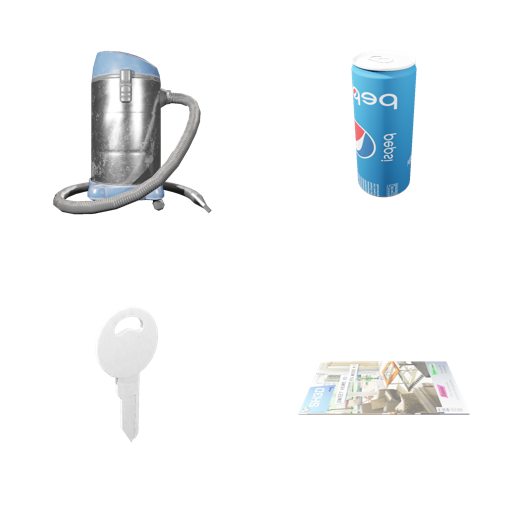

 20%|██        | 1/5 [00:22<01:28, 22.22s/it]

{'answer': 'top left',
 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FD8D9E56F80>,
 'image_metadata': {'grid number': 2,
                    'grids': [0, 1, 2, 3],
                    'object paths': ['/mnt/sdb1/dynabench-source/object_images/Q101674/9043d7516953498ea001f74914e50db8/000.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q147538/c4e1108230c04e3882a0fc37464aeb0d/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q132041/6dd58550d86b4d2fb21017b0faf443cf/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q41298/dbf953026bfd45ddab67f6554c1018ad/003.png'],
                    'objects': ['9043d7516953498ea001f74914e50db8',
                                'c4e1108230c04e3882a0fc37464aeb0d',
                                '6dd58550d86b4d2fb21017b0faf443cf',
                                'dbf953026bfd45ddab67f6554c1018ad']},
 'options': ['top left', 't

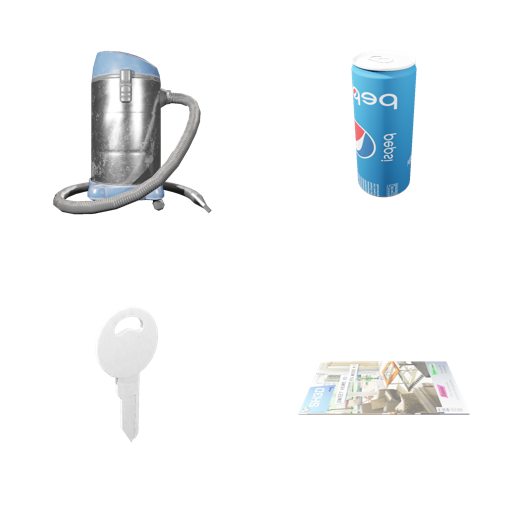

 40%|████      | 2/5 [00:44<01:06, 22.25s/it]

{'answer': '1',
 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FD8D9E56FB0>,
 'image_metadata': {'grid number': 2,
                    'grids': [0, 1, 2, 3],
                    'object paths': ['/mnt/sdb1/dynabench-source/object_images/Q1317634/c93105da9e7f4b38b6e59e285102f954/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q134560/6f1ac304029143b79f038536d79480e6/003.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q11472/d87bb6f3afdb4bd98b100fd14d70c585/000.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q14963/b01d81c8f6d341c389b3f4dba84aa3f0/001.png'],
                    'objects': ['c93105da9e7f4b38b6e59e285102f954',
                                '6f1ac304029143b79f038536d79480e6',
                                'd87bb6f3afdb4bd98b100fd14d70c585',
                                'b01d81c8f6d341c389b3f4dba84aa3f0']},
 'options': ['1', '2', '3', '4'],


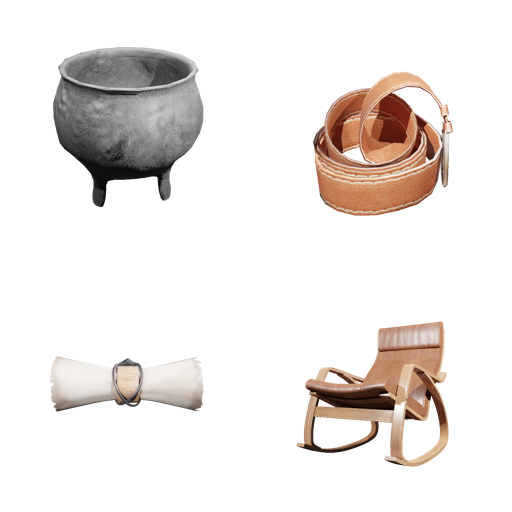

 60%|██████    | 3/5 [00:44<00:24, 12.19s/it]

{'answer': 'cylinder',
 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FD8D9E7C4C0>,
 'image_metadata': {'grid number': 2,
                    'grids': [0, 1, 2, 3],
                    'object paths': ['/mnt/sdb1/dynabench-source/object_images/Q101674/9043d7516953498ea001f74914e50db8/000.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q147538/c4e1108230c04e3882a0fc37464aeb0d/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q132041/6dd58550d86b4d2fb21017b0faf443cf/005.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q41298/dbf953026bfd45ddab67f6554c1018ad/003.png'],
                    'objects': ['9043d7516953498ea001f74914e50db8',
                                'c4e1108230c04e3882a0fc37464aeb0d',
                                '6dd58550d86b4d2fb21017b0faf443cf',
                                'dbf953026bfd45ddab67f6554c1018ad']},
 'options': ['cylinder', 'o

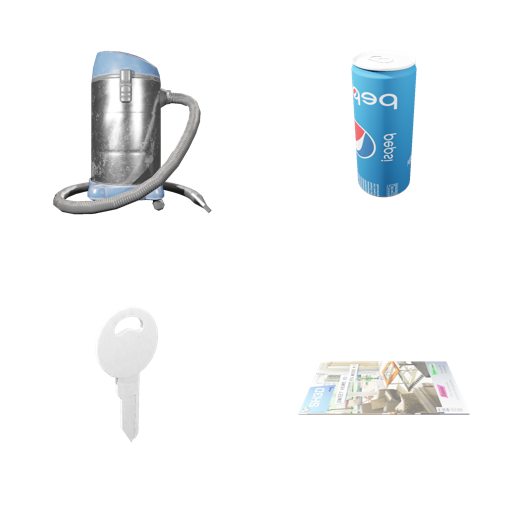

 80%|████████  | 4/5 [01:01<00:14, 14.16s/it]

{'answer': 'top left',
 'image': <PIL.Image.Image image mode=RGB size=512x512 at 0x7FD8D9E7D4B0>,
 'image_metadata': {'grid number': 2,
                    'grids': [0, 1, 2, 3],
                    'object paths': ['/mnt/sdb1/dynabench-source/object_images/Q101674/9043d7516953498ea001f74914e50db8/000.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q16868432/bf4bf83a62fb49ee86aab3bbf3ce73c0/004.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q16629185/667e4db600f748708d7e03fac3e28963/003.png',
                                     '/mnt/sdb1/dynabench-source/object_images/Q133792/d587a871eade4dd89ae5d7b45421a74c/000.png'],
                    'objects': ['9043d7516953498ea001f74914e50db8',
                                'bf4bf83a62fb49ee86aab3bbf3ce73c0',
                                '667e4db600f748708d7e03fac3e28963',
                                'd587a871eade4dd89ae5d7b45421a74c']},
 'options': ['top left

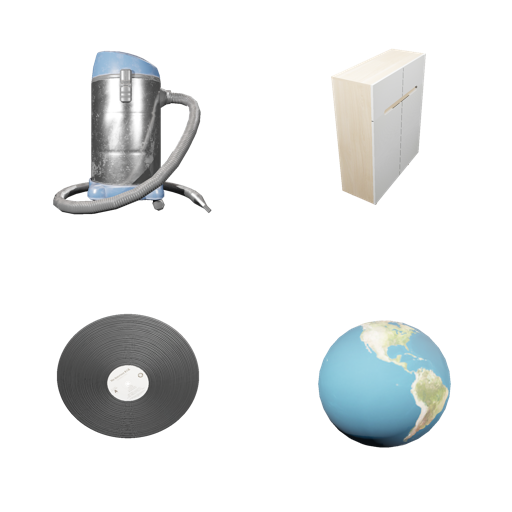

100%|██████████| 5/5 [01:19<00:00, 15.92s/it]


In [6]:
import pandas as pd
import pyarrow.parquet as pq
from tma.task_store import get_pd_schema
from tqdm import tqdm
from pprint import pprint # use pprint to print the task

types = ['what', 'where', 'how many', 'what attribute', 'where attribute'] # select the types of task plans you want
filters = [[('task type', '==', t)] for t in types]

pool = []
sample_num = 100
idx = 0
save_path = '../cache/2d_sticker.parquet'

for filter in tqdm(filters):
    df = pq.read_table(save_path, filters=filter).to_pandas().astype(get_pd_schema(generator.schema))
    df.iloc[idx].dropna()
    task = generator.generate(df.iloc[idx].dropna().to_dict(), return_data=True)
    pprint(task)
    display(task['image'])

    if len(df) > sample_num:
        df = df.sample(sample_num)
    pool.append(df)

Above is 5 VQA test cases generated from different types of generators. 

The dataframe below is the example task plans we sampled from the parquet file:

The values start with "Q" in the `target category`, `reference category` columns of the returned dataframe is the QID of the category, which corresponds to a Wikidata entry (eg,  `Q11422` corresponds to https://www.wikidata.org/wiki/Q11422).

Note that different question types have different schema, For example, for "what" type question, we don't need count, so the `count` column is `<NA>`.

In [7]:
df = pd.concat(pool)
df

,task type,grid number,target category,absolute position,reference category,reference position,attribute type,attribute value,count
12581930,what,3,Q1357,middle right,Q28692583,top right,color,beige,<NA>
22556163,what,3,Q1780509,middle right,Q200539,top,material,plastic,<NA>
49751530,what,3,Q6147804,top middle,Q13317,left,color,red,<NA>
11107175,what,3,Q132397,top left,Q1047832,left,shape,cylinder,<NA>
24410432,what,2,Q188075,top right,Q182780,top,color,red,<NA>
...,...,...,...,...,...,...,...,...,...
17352864,where attribute,3,Q173725,middle,Q862454,top right,shape,cuboid,<NA>
5510703,where attribute,3,Q121916,top middle,Q56139,left,material,plastic,<NA>
45630717,where attribute,3,Q89,top middle,Q987767,top left,color,red,<NA>
36162159,where attribute,3,Q4498085,middle,Q7927908,bottom,shape,cylinder,<NA>
